# **YOLOv8 VALIDATION**

## **Initial configuration**

**Install packages**

In [1]:
#!pip install ultralytics==8.2.103

**Import libraries**

In [2]:
import glob
import matplotlib.pyplot as plt
import os
import shutil
import subprocess
import torch
import yaml

from ultralytics import YOLO
from PIL import Image

In [4]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4034MiB)
Setup complete ✅ (8 CPUs, 7.6 GB RAM, 69.0/294.2 GB disk)


**Graphic card features**

In [5]:
# Verify cuda available device
cuda_device_num = torch.cuda.device_count()
if not cuda_device_num:
  print("\033[93m WARNING: No cuda devices found. \033[0m")
else:
  print(f"\033[34m INFO: There {'is' if cuda_device_num == 1 else 'are'} {cuda_device_num} pytorch cuda devices. \033[0m")
  print(f"\033[34m       Pyorch cuda version: {torch.version.cuda} \033[0m")
  print(f"\033[34m-\033[0m" * 35)
  for index in  range(cuda_device_num):
    print(f"\033[34m GPU {index}: {torch.cuda.get_device_name(index)} \033[0m")
    print(f"\033[34m \tTotal cuda device memory {torch.cuda.mem_get_info(0)[1] // 2 ** 20} MiB\033[0m")
    print(f"\033[34m \tFree cuda device memory {torch.cuda.mem_get_info(index)[0] // 2 ** 20} MiB\033[0m\n")

  print("Graphics card information")
  print(subprocess.check_output("nvidia-smi").decode())

 INFO: There is 1 pytorch cuda devices. 
       Pyorch cuda version: 12.4 
-----------------------------------
 GPU 0: NVIDIA GeForce GTX 1050 Ti 
 	Total cuda device memory 4034 MiB
 	Free cuda device memory 3986 MiB

Graphics card information
Mon Jan 27 19:49:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off |   00000000:01:00.0 Off |           

**Directory structure**

In [6]:
# Run local or not
PROJ_ROOT = os.getcwd()
local = True if os.path.basename(PROJ_ROOT) == "notebooks" else False

# Directories path
if not local:
  os.makedirs("models", exist_ok=True)
  data_relative_path ="data"
  models_relative_path = "models"
else:
  data_relative_path ="../data/processed"
  models_relative_path = "../models"

MODELS_DIR = os.path.join(PROJ_ROOT, models_relative_path)
PROCESSED_DATA_DIR = os.path.join(PROJ_ROOT, data_relative_path)

# Print directories paths
print(f"\033[34m INFO: Models in {MODELS_DIR} \033[0m")
print(f"\033[34m INFO: Processed data in {PROCESSED_DATA_DIR} \033[0m")

 INFO: Models in /home/harvey/Documents/yolo_ppe_detection/notebooks/../models 
 INFO: Processed data in /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed 


**Configuration variables**

In [7]:
# Configuration class
class CFG:
  # Classes
  CLASSES = ["hard_hat",
            "no_hard_hat",
            "no_safety_harness",
            "no_safety_vest",
            "person",
            "safety_harness",
            "safety_vest"]

  # Dataset
  DATASET_VERSION = 5
  DATASET_NAME = f"ppe_dataset_v{DATASET_VERSION}"
  DATASET_PATH = os.path.join(PROCESSED_DATA_DIR, DATASET_NAME)
  DATASET_YAML_PATH = os.path.join(DATASET_PATH, "data.yaml")

  # Valid variables
  VALID_DEVICE = "0" if cuda_device_num else "cpu"
  VALID_MODEL_PATH = "/home/harvey/Documents/yolo_ppe_detection/models/bestml.pt"
  VALID_PROJECT_NAME = ""
  VALID_PROJECT_PATH = os.path.join(MODELS_DIR, VALID_PROJECT_NAME)
  VALID_NAME = ""

# Print information
print("\033[34m INFO: The configuration is ready for VALIDATION. \033[0m")

print(f"\nDataset information")
print(f"Dataset path: {CFG.DATASET_PATH}")

print("\nTraining information")
print(f"Valid model path: {CFG.VALID_MODEL_PATH}")
print(f"Valid project path: {CFG.VALID_PROJECT_PATH}")
print(f"Valid name: {CFG.VALID_NAME}")

 INFO: The configuration is ready for VALIDATION. 

Dataset information
Dataset path: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5

Training information
Valid model path: /home/harvey/Documents/yolo_ppe_detection/models/bestml.pt
Valid project path: /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/
Valid name: 


## **Dataset**

**Verify dataset**

In [8]:
# Dataset paths
dataset_path_exist = os.path.isdir(CFG.DATASET_PATH)
dataset_yaml_file_exist = os.path.isfile(CFG.DATASET_YAML_PATH)

# Check if path exists
if not dataset_path_exist or not dataset_yaml_file_exist:
  print("\033[93m WARNING: Check dataset path or download again. \033[0m")
else:
  print("\033[34m INFO: The dataset exists. \033[0m\n")
  # Plot dataset yaml file
  with open(CFG.DATASET_YAML_PATH, "r") as file:
    try:
      data = yaml.safe_load(file)
      yaml_data = yaml.dump(data, default_style=False)
      print(yaml_data)

    except yaml.YAMLError as e:
      print("Error reading YAML: ", e)
  file.close()

 INFO: The dataset exists. 

names:
- hard_hat
- no_hard_hat
- no_safety_harness
- no_safety_vest
- person
- safety_harness
- safety_vest
nc: 7
roboflow:
  license: CC BY 4.0
  project: yolo_ppe_detection
  url: https://universe.roboflow.com/deeplearning-cwudo/yolo_ppe_detection/dataset/5
  version: 5
  workspace: deeplearning-cwudo
test: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/test/images
train: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/train/images
val: /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/valid/images



## **Validation**

**Verify the dataset**

In [9]:
if not os.path.isfile(CFG.VALID_MODEL_PATH):
  print(f"\033[31m ERROR: Is posible the trained model {CFG.VALID_MODEL_PATH} don't exist. \033[0m")
else:
  print(f"\033[34m INFO: The trained model {CFG.VALID_MODEL_PATH} exists. \033[0m")

 INFO: The trained model /home/harvey/Documents/yolo_ppe_detection/models/bestml.pt exists. 


**Load de model**

In [10]:
try:
  valid_model = YOLO(CFG.VALID_MODEL_PATH)
  print(f"The {CFG.VALID_MODEL_PATH} was loaded.")
except:
  print(f"Error loading the {CFG.VALID_MODEL_PATH} model.")

The /home/harvey/Documents/yolo_ppe_detection/models/bestml.pt was loaded.


**Validation settings**

In [11]:
# Project configuration
valid_project_name = CFG.VALID_PROJECT_NAME if CFG.VALID_PROJECT_NAME else f"valid_{valid_model.ckpt["train_args"]["project"].split("/")[-1]}"
valid_name = CFG.VALID_NAME if CFG.VALID_NAME else valid_model.ckpt["train_args"]["name"]
valid_project_path = os.path.join(MODELS_DIR, valid_project_name)

valid_path = os.path.join(valid_project_path, valid_name)
if os.path.isdir(valid_path):
  shutil.rmtree(valid_path)

print("Valid model path:\t", CFG.VALID_MODEL_PATH)
print("Valid project name:\t", valid_project_name)
print("Valid project path:\t", valid_project_path)
print("Valid name:\t", valid_name)

Valid model path:	 /home/harvey/Documents/yolo_ppe_detection/models/bestml.pt
Valid project name:	 valid_train_yolov8m_ppe_detection
Valid project path:	 /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/valid_train_yolov8m_ppe_detection
Valid name:	 pt_500_epochs


In [12]:
cfg_valid = {
  "data": CFG.DATASET_YAML_PATH,
  "imgsz": 640,
  "batch": 16,
  "save_json": False,
  "save_hybrid": False,
  "conf": 0.001,
  "iou": 0.6,
  "half": True,
  "device": CFG.VALID_DEVICE,
  "plots": True,
  "rect": True,
  "split": "val",
  "project": valid_project_path,
  "name": valid_name
}

for key, value in cfg_valid.items():
  print(key, ":", value)

data : /home/harvey/Documents/yolo_ppe_detection/notebooks/../data/processed/ppe_dataset_v5/data.yaml
imgsz : 640
batch : 16
save_json : False
save_hybrid : False
conf : 0.001
iou : 0.6
half : True
device : 0
plots : True
rect : True
split : val
project : /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/valid_train_yolov8m_ppe_detection
name : pt_500_epochs


**Model information**

In [13]:
valid_model.info()

Model summary: 295 layers, 25,860,373 parameters, 0 gradients, 79.1 GFLOPs


(295, 25860373, 0, 79.0849536)

**Model validation**

In [14]:
valid_metrics = valid_model.val(**cfg_valid)

Ultralytics YOLOv8.2.103 🚀 Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4034MiB)
Model summary (fused): 218 layers, 25,843,813 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /home/harvey/Documents/yolo_ppe_detection/data/processed/ppe_dataset_v5/valid/labels.cache... 1001 images, 21 backgrounds, 0 corrupt: 100%|██████████| 1001/1001 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


                   all       1001       8600      0.897      0.911      0.946      0.738
              hard_hat        694       1875      0.936      0.942       0.97      0.783
           no_hard_hat        304        868      0.934      0.934      0.963      0.745
     no_safety_harness        353        895      0.781      0.847      0.872      0.653
        no_safety_vest        619       1578      0.889      0.906      0.943      0.643
                person        865       2347      0.908      0.944      0.958      0.782
        safety_harness        203        268      0.941      0.892      0.965      0.783
           safety_vest        339        769      0.892       0.91      0.953      0.774
Speed: 0.5ms preprocess, 54.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /home/harvey/Documents/yolo_ppe_detection/notebooks/../models/valid_train_yolov8m_ppe_detection/pt_500_epochs


**Valid metrics**

In [15]:
print("map50-95", ":", valid_metrics.box.map)
print("map50", ":", valid_metrics.box.map50)
print("map75", ":", valid_metrics.box.map75)
print("maps", ":", valid_metrics.box.maps)

map50-95 : 0.7375691640231098
map50 : 0.9461757463689383
map75 : 0.8650173955042744
maps : [    0.78289     0.74459     0.65349     0.64326     0.78205     0.78281      0.7739]


**Images of the metrics and validation**

In [16]:
valid_metrics_path = valid_metrics.save_dir
valid_image_files = [
  i for i in
  glob.glob(f"{valid_metrics_path}/*.png") + glob.glob(f"{valid_metrics_path}/*.jpg")
]

valid_image_files

['/home/harvey/Documents/yolo_ppe_detection/notebooks/../models/valid_train_yolov8m_ppe_detection/pt_500_epochs/PR_curve.png',
 '/home/harvey/Documents/yolo_ppe_detection/notebooks/../models/valid_train_yolov8m_ppe_detection/pt_500_epochs/F1_curve.png',
 '/home/harvey/Documents/yolo_ppe_detection/notebooks/../models/valid_train_yolov8m_ppe_detection/pt_500_epochs/P_curve.png',
 '/home/harvey/Documents/yolo_ppe_detection/notebooks/../models/valid_train_yolov8m_ppe_detection/pt_500_epochs/R_curve.png',
 '/home/harvey/Documents/yolo_ppe_detection/notebooks/../models/valid_train_yolov8m_ppe_detection/pt_500_epochs/confusion_matrix_normalized.png',
 '/home/harvey/Documents/yolo_ppe_detection/notebooks/../models/valid_train_yolov8m_ppe_detection/pt_500_epochs/confusion_matrix.png',
 '/home/harvey/Documents/yolo_ppe_detection/notebooks/../models/valid_train_yolov8m_ppe_detection/pt_500_epochs/val_batch2_labels.jpg',
 '/home/harvey/Documents/yolo_ppe_detection/notebooks/../models/valid_train_y

**Plot images of the results**

F1_curve.png


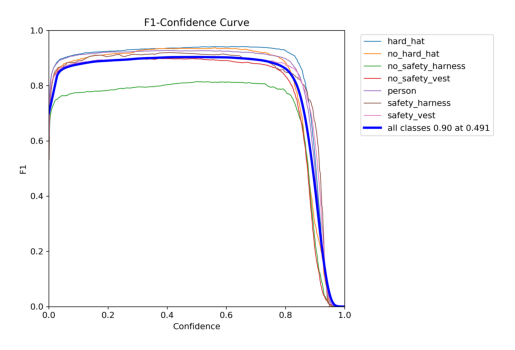



PR_curve.png


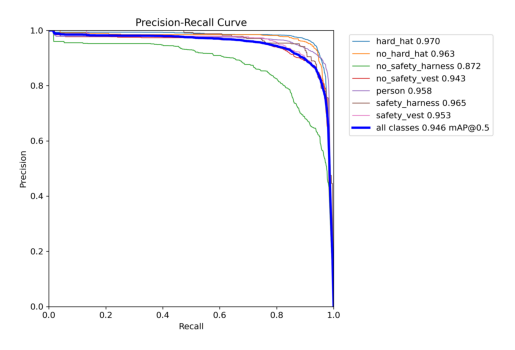



P_curve.png


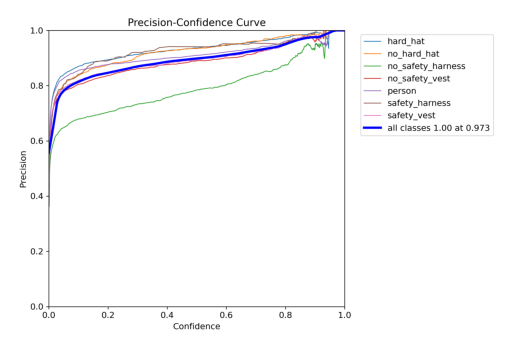



R_curve.png


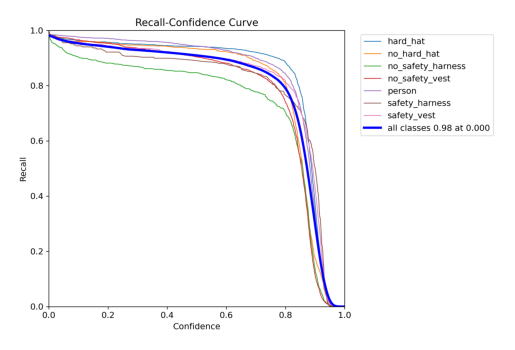



confusion_matrix.png


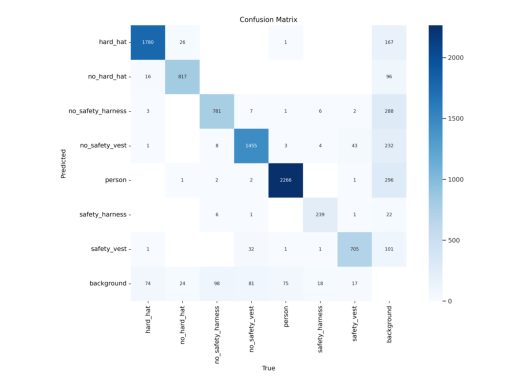



confusion_matrix_normalized.png


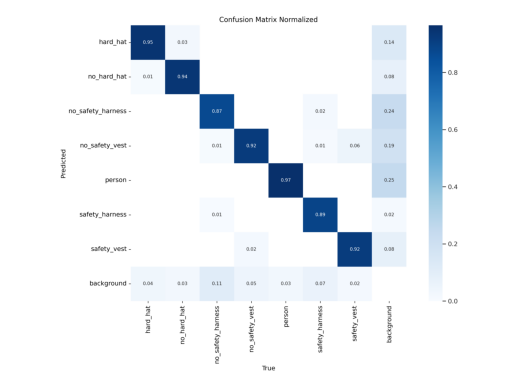



val_batch0_labels.jpg


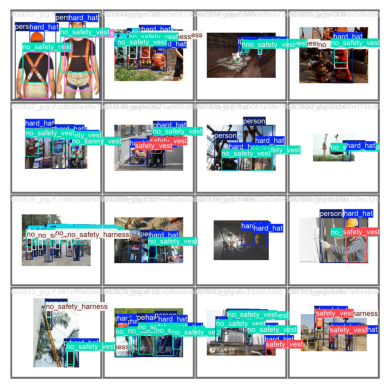



val_batch0_pred.jpg


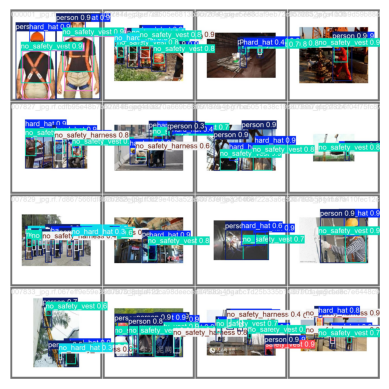



val_batch1_labels.jpg


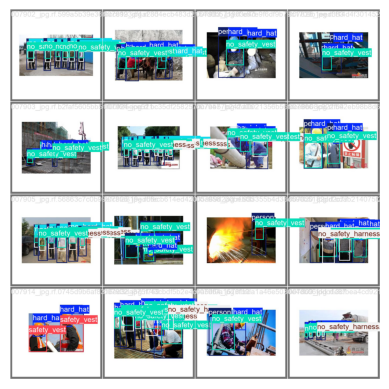



val_batch1_pred.jpg


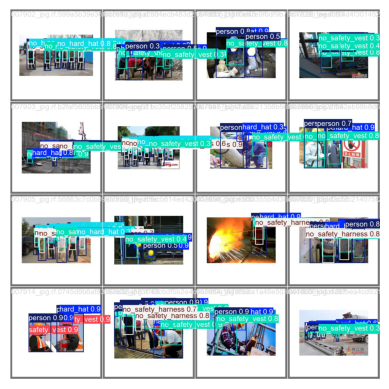



val_batch2_labels.jpg


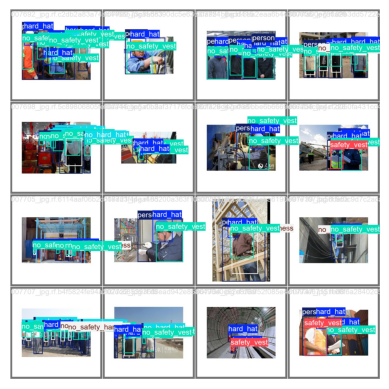



val_batch2_pred.jpg


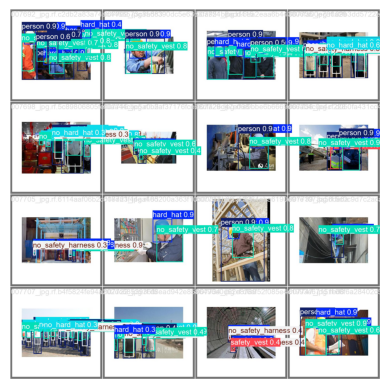

In [17]:
for image in sorted(valid_image_files):
  image_name = image.split("/")[-1]
  print(image_name)

  img = Image.open(image)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

  print("\n")